In [ ]:
# SETUP & CONFIGURATION
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from pathlib import Path
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, random_split
from torchvision import datasets, models, transforms
from google.colab import drive

# 1. Mount Google Drive
drive.mount('/content/drive')

# 2. Configuration

ZIP_PATH = "/content/drive/MyDrive/Yara/DL_PROJECT_DATASET.zip"

# Working Directories
EXTRACT_PATH = "./dataset_root"
RESIZED_PATH = "./dataset_resized_224"

# Hyperparameters
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 15
SEED = 42         # Fixed Seed for Reproducibility
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"[*] Setup Complete. Using Device: {DEVICE}")

Mounted at /content/drive
[*] Setup Complete. Using Device: cuda


In [ ]:
# EXTRACTION & OFFLINE RESIZING
def prepare_data():
    # 1. Extract ZIP if not exists
    if not os.path.exists(EXTRACT_PATH):
        print(f"[*] Extracting dataset...")
        with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
            zip_ref.extractall(EXTRACT_PATH)

    # 2. Locate the dataset folder
    source_data_dir = None
    for root, dirs, files in os.walk(EXTRACT_PATH):
        if "car" in [d.lower() for d in dirs]:
            source_data_dir = Path(root)
            break

    if source_data_dir is None:
        print("[!] Error: Could not locate dataset folder.")
        return None

    # 3. Resize Images (Optimization step to speed up training)
    if os.path.exists(RESIZED_PATH):
        print(f"[*] Resized data found. Skipping resizing.")
        return RESIZED_PATH

    print(f"[*] Resizing images to {IMG_SIZE}x{IMG_SIZE}...")
    dest_path = Path(RESIZED_PATH)
    dest_path.mkdir(parents=True, exist_ok=True)

    # Gather all images
    extensions = ['*.jpg', '*.jpeg', '*.png', '*.heic']
    files_list = []
    for ext in extensions:
        files_list.extend(list(source_data_dir.rglob(ext)))

    # Resize and save as clean JPGs
    for file_path in tqdm(files_list):
        try:
            relative_path = file_path.relative_to(source_data_dir)
            final_dest = dest_path / relative_path
            final_dest.parent.mkdir(parents=True, exist_ok=True)

            img = Image.open(file_path).convert('RGB')
            img = img.resize((IMG_SIZE, IMG_SIZE), Image.Resampling.LANCZOS)
            img.save(final_dest, "JPEG", quality=90)
        except Exception:
            pass

    return RESIZED_PATH

# Run Prep
FINAL_DATA_PATH = prepare_data()
print(f"[*] Final Data Path: {FINAL_DATA_PATH}")

[*] Extracting dataset...
[*] Resizing images to 224x224...


 25%|██▍       | 583/2363 [01:14<06:03,  4.89it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
100%|██████████| 2363/2363 [08:32<00:00,  4.61it/s]

[*] Final Data Path: ./dataset_resized_224


In [ ]:
#DATA LOADING & SPLITTING (CORRECTED)
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms
import numpy as np
import torch

if FINAL_DATA_PATH:
    print("[*] Setting up Data Loaders...")

    # 1. Enforce Reproducibility
    torch.manual_seed(SEED)
    np.random.seed(SEED)

    # 2. Define Transforms
    # Training: Augmentation
    train_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    # Val/Test: No Augmentation
    val_test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    # 3. Load Dataset
    full_dataset = datasets.ImageFolder(FINAL_DATA_PATH)
    class_names = full_dataset.classes
    print(f"Classes: {class_names}")

    # 4. Standard Split (70% Train, 15% Val, 15% Test)
    total = len(full_dataset)
    train_cnt = int(0.70 * total)
    val_cnt = int(0.15 * total)
    test_cnt = total - train_cnt - val_cnt

    gen = torch.Generator().manual_seed(SEED)
    train_set, val_set, test_set = random_split(full_dataset, [train_cnt, val_cnt, test_cnt], generator=gen)

    # --- FIX: Robust Wrapper Class ---
    # This class wraps the subset and applies the transform correctly
    class TransformSubset(Dataset):
        def __init__(self, subset, transform=None):
            self.subset = subset
            self.transform = transform

        def __getitem__(self, index):
            x, y = self.subset[index] # Get image and label
            if self.transform:
                x = self.transform(x) # Apply transform (includes ToTensor)
            return x, y

        def __len__(self):
            return len(self.subset)
    # ---------------------------------

    train_ds = TransformSubset(train_set, transform=train_transform)
    val_ds = TransformSubset(val_set, transform=val_test_transform)
    test_ds = TransformSubset(test_set, transform=val_test_transform)

    dataloaders = {
        'train': DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True),
        'val':   DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False),
        'test':  DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)
    }
    print(f"[*] Data Ready. Train: {len(train_ds)}, Val: {len(val_ds)}, Test: {len(test_ds)}")
else:
    print("[!] Cannot proceed. Data path is invalid.")

[*] Setting up Data Loaders...
Classes: ['building', 'car', 'lab', 'person', 'tree']
[*] Data Ready. Train: 1654, Val: 354, Test: 355


In [ ]:
# [CELL 4] MODEL DEFINITIONS (WITH CBAM)
import torch.nn as nn
from torchvision import models
import torch

# --- A. NOVELTY: CBAM (Channel + Spatial Attention) ---
class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc1   = nn.Conv2d(in_planes, in_planes // ratio, 1, bias=False)
        self.relu1 = nn.ReLU()
        self.fc2   = nn.Conv2d(in_planes // ratio, in_planes, 1, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc2(self.relu1(self.fc1(self.avg_pool(x))))
        max_out = self.fc2(self.relu1(self.fc1(self.max_pool(x))))
        out = avg_out + max_out
        return self.sigmoid(out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=3, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)

class CBAM(nn.Module):
    def __init__(self, planes, ratio=16, kernel_size=7):
        super(CBAM, self).__init__()
        self.ca = ChannelAttention(planes, ratio)
        self.sa = SpatialAttention(kernel_size)

    def forward(self, x):
        out = x * self.ca(x)
        out = out * self.sa(out)
        return out

# --- B. BASELINE MODEL (Frozen DenseNet) ---
def build_baseline_densenet():
    print("[*] Building Baseline Model (Standard)...")
    model = models.densenet121(weights='IMAGENET1K_V1')
    for param in model.features.parameters():
        param.requires_grad = False

    num_ftrs = model.classifier.in_features
    model.classifier = nn.Sequential(
        nn.Linear(num_ftrs, 512),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(512, len(class_names))
    )
    return model.to(DEVICE)

# --- C. PROPOSED MODEL (Fine-Tuned CBAM-DenseNet) ---
class CBAMDenseNet(nn.Module):
    def __init__(self, num_classes):
        super(CBAMDenseNet, self).__init__()
        base_model = models.densenet121(weights='IMAGENET1K_V1')
        self.features = base_model.features

        # Unfreeze Last Block for Better Accuracy
        for param in self.features.parameters():
            param.requires_grad = False
        for param in self.features.denseblock4.parameters():
            param.requires_grad = True
        for param in self.features.norm5.parameters():
            param.requires_grad = True

        # Novelty: CBAM
        self.cbam = CBAM(planes=1024, ratio=16)

        self.relu = nn.ReLU(inplace=True)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.cbam(x)      # Attention Mechanism
        x = self.relu(x)
        x = self.avgpool(x)
        x = self.classifier(x)
        return x

def build_improved_cbam_densenet():
    print("[*] Building Novelty Model (CBAM-DenseNet)...")
    return CBAMDenseNet(len(class_names)).to(DEVICE)

In [ ]:
# [CELL 4] MODEL DEFINITIONS (CBAM NOVELTY)
import torch.nn as nn
from torchvision import models
import torch

# --- A. NOVELTY: CBAM (Channel + Spatial Attention) ---
class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc1   = nn.Conv2d(in_planes, in_planes // ratio, 1, bias=False)
        self.relu1 = nn.ReLU()
        self.fc2   = nn.Conv2d(in_planes // ratio, in_planes, 1, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc2(self.relu1(self.fc1(self.avg_pool(x))))
        max_out = self.fc2(self.relu1(self.fc1(self.max_pool(x))))
        out = avg_out + max_out
        return self.sigmoid(out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=3, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)

class CBAM(nn.Module):
    def __init__(self, planes, ratio=16):
        super(CBAM, self).__init__()
        self.ca = ChannelAttention(planes, ratio)
        self.sa = SpatialAttention()

    def forward(self, x):
        out = x * self.ca(x)
        out = out * self.sa(out)
        return out

# --- B. BASELINE MODEL (Standard DenseNet) ---
def build_baseline_densenet():
    print("[*] Building Baseline Model...")
    model = models.densenet121(weights='IMAGENET1K_V1')
    for param in model.features.parameters():
        param.requires_grad = False

    num_ftrs = model.classifier.in_features
    model.classifier = nn.Sequential(
        nn.Linear(num_ftrs, 512),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(512, len(class_names))
    )
    return model.to(DEVICE)

# --- C. PROPOSED MODEL (CBAM-DenseNet) ---
class CBAMDenseNet(nn.Module):
    def __init__(self, num_classes):
        super(CBAMDenseNet, self).__init__()
        base_model = models.densenet121(weights='IMAGENET1K_V1')
        self.features = base_model.features

        # Fine-Tuning: Unfreeze last block
        for param in self.features.parameters():
            param.requires_grad = False
        for param in self.features.denseblock4.parameters():
            param.requires_grad = True
        for param in self.features.norm5.parameters():
            param.requires_grad = True

        # Novelty: CBAM (1024 channels for DenseNet121)
        self.cbam = CBAM(planes=1024, ratio=16)

        self.relu = nn.ReLU(inplace=True)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.cbam(x)      # Apply Attention
        x = self.relu(x)
        x = self.avgpool(x)
        x = self.classifier(x)
        return x

def build_improved_cbam_densenet():
    print("[*] Building Proposed Novelty Model (CBAM)...")
    return CBAMDenseNet(len(class_names)).to(DEVICE)

In [ ]:
# [CELL 5] TRAINING FUNCTION (FIXED TABLE FORMAT)
import copy
import torch.optim as optim

def train_engine(model, name="Model"):
    criterion = nn.CrossEntropyLoss()
    # Keeping logic exactly the same
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=2)

    best_acc = 0.0
    best_wts = copy.deepcopy(model.state_dict())

    history = {'val_loss': [], 'val_acc': []}

    print(f"\n[+] Starting Training: {name}")
    print("-" * 55)
    # Using fixed width formatting (<10 means align left with 10 spaces)
    print(f"{'Epoch':<10} | {'Val Loss':<15} | {'Val Acc':<15}")
    print("-" * 55)

    for epoch in range(EPOCHS):
        # Training
        model.train()
        for inputs, labels in dataloaders['train']:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        val_corrects = 0
        val_loss = 0.0
        total = 0
        with torch.no_grad():
            for inputs, labels in dataloaders['val']:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)
                val_corrects += torch.sum(preds == labels.data)
                val_loss += loss.item() * inputs.size(0)
                total += labels.size(0)

        val_acc = val_corrects.double() / total
        epoch_val_loss = val_loss / total

        history['val_acc'].append(val_acc.item())
        history['val_loss'].append(epoch_val_loss)

        scheduler.step(epoch_val_loss)

        if val_acc > best_acc:
            best_acc = val_acc
            best_wts = copy.deepcopy(model.state_dict())

        # FORMAT FIX: ensuring values align perfectly under headers
        epoch_str = f"{epoch+1}/{EPOCHS}"
        print(f"{epoch_str:<10} | {epoch_val_loss:<15.4f} | {val_acc:<15.4f}")

    print("-" * 55)
    print(f"[*] BEST VALIDATION ACCURACY: {best_acc:.4f}")
    model.load_state_dict(best_wts)
    return model, best_acc, history

[*] Building Baseline Model...

[+] Starting Training: Baseline
-------------------------------------------------------
Epoch      | Val Loss        | Val Acc        
-------------------------------------------------------
1/15       | 0.9056          | 0.8333         
2/15       | 0.5676          | 0.8785         
3/15       | 0.4336          | 0.8983         
4/15       | 0.3440          | 0.9011         
5/15       | 0.3191          | 0.8983         
6/15       | 0.2958          | 0.9096         
7/15       | 0.2897          | 0.9040         
8/15       | 0.2659          | 0.9040         
9/15       | 0.2749          | 0.9068         
10/15      | 0.2629          | 0.9124         
11/15      | 0.2539          | 0.9124         
12/15      | 0.2501          | 0.9096         
13/15      | 0.2222          | 0.9153         
14/15      | 0.2340          | 0.9181         
15/15      | 0.2237          | 0.9068         
-------------------------------------------------------
[*] BEST VALIDAT

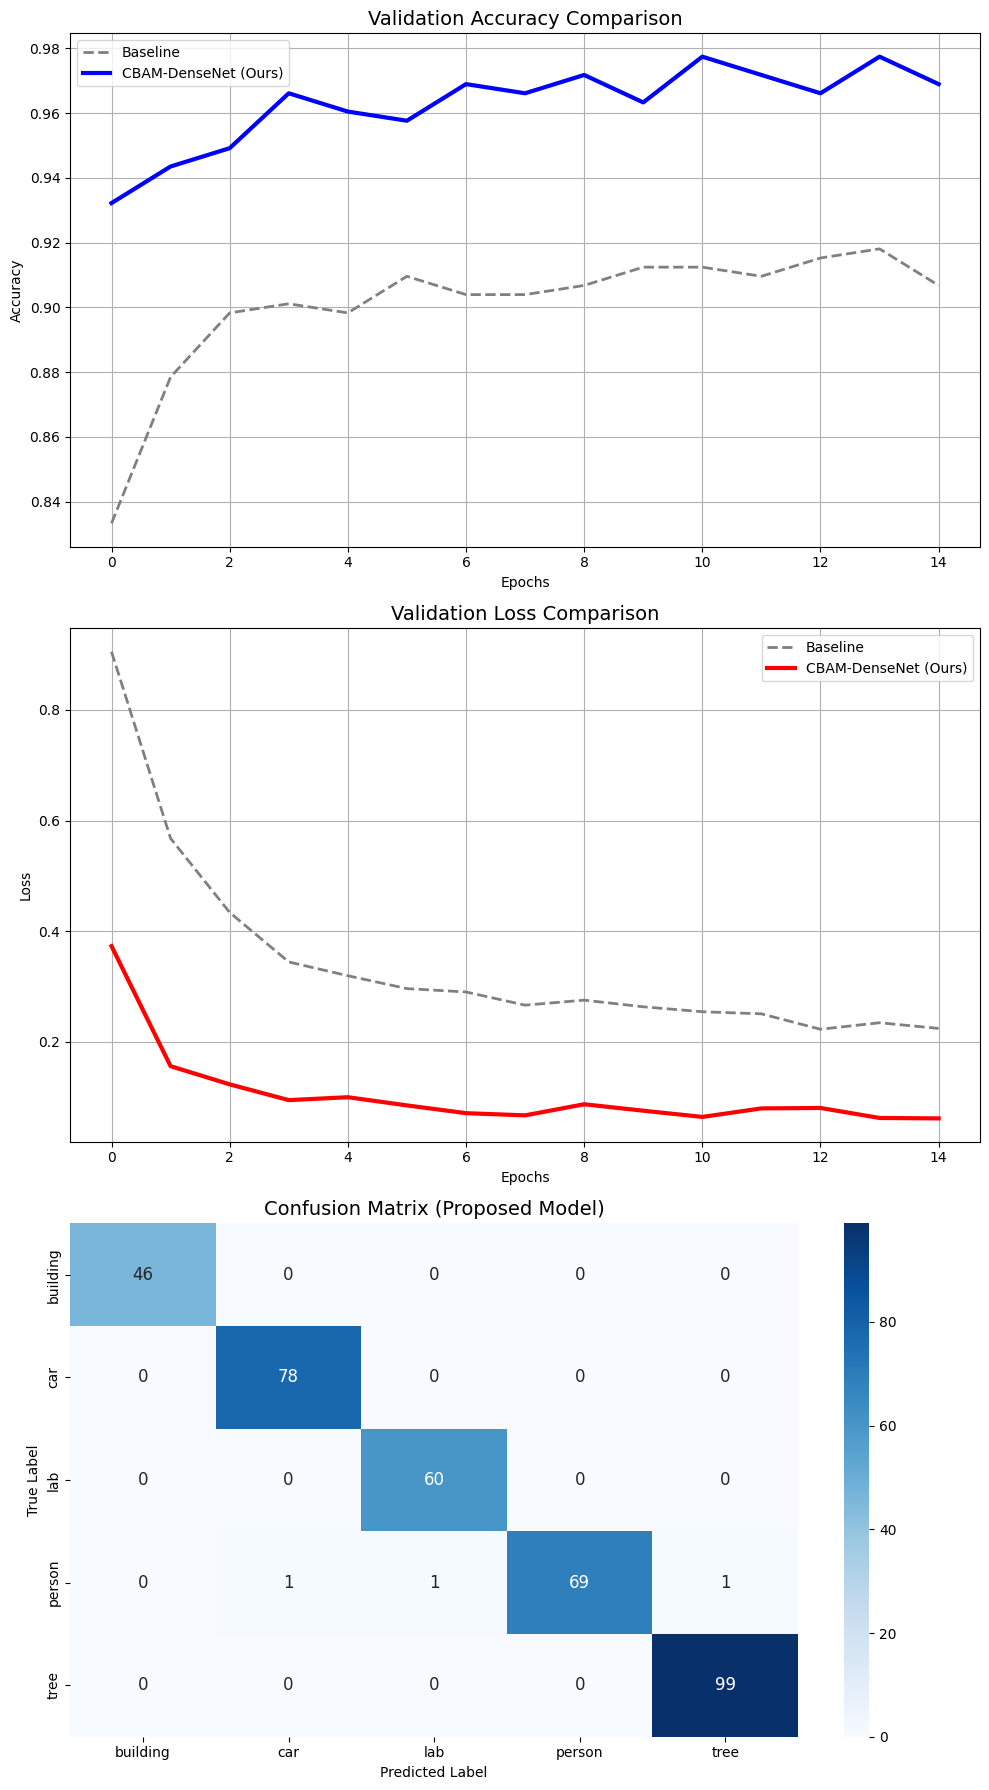


FINAL IMPROVEMENT ON TEST SET: +3.38%


In [ ]:
#EXECUTION & EVALUATION (VERTICAL PLOTS)
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Train Baseline
baseline_model = build_baseline_densenet()
base_model, base_acc, base_hist = train_engine(baseline_model, "Baseline")

# 2. Train Novelty (CBAM)
novelty_model = build_improved_cbam_densenet()
our_model, our_acc, our_hist = train_engine(novelty_model, "Proposed (CBAM)")

# 3. Final Evaluation
def evaluate_test(model, name):
    print(f"\n[*] Evaluating {name} on TEST SET...")
    model.eval()
    all_preds = []
    all_labels = []
    corrects = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloaders['test']:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            corrects += torch.sum(preds == labels.data)
            total += labels.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = corrects.double() / total
    print(f"[*] {name} FINAL TEST ACCURACY: {acc:.4f}")
    return acc.item(), all_labels, all_preds

base_test_acc, _, _ = evaluate_test(base_model, "Baseline")
our_test_acc, our_labels, our_preds = evaluate_test(our_model, "Proposed (CBAM)")

# 4. Visualization (VERTICAL STACK)
# Changed figsize to be tall and narrow (10x18)
plt.figure(figsize=(10, 18))

# Plot 1: Validation Accuracy
plt.subplot(3, 1, 1) # 3 rows, 1 col, index 1
plt.plot(base_hist['val_acc'], label='Baseline', linestyle='--', color='gray', linewidth=2)
plt.plot(our_hist['val_acc'], label='CBAM-DenseNet (Ours)', linewidth=3, color='blue')
plt.title('Validation Accuracy Comparison', fontsize=14)
plt.xlabel('Epochs'); plt.ylabel('Accuracy'); plt.legend(); plt.grid(True)

# Plot 2: Validation Loss
plt.subplot(3, 1, 2) # 3 rows, 1 col, index 2
plt.plot(base_hist['val_loss'], label='Baseline', linestyle='--', color='gray', linewidth=2)
plt.plot(our_hist['val_loss'], label='CBAM-DenseNet (Ours)', linewidth=3, color='red')
plt.title('Validation Loss Comparison', fontsize=14)
plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.legend(); plt.grid(True)

# Plot 3: Confusion Matrix
plt.subplot(3, 1, 3) # 3 rows, 1 col, index 3
cm = confusion_matrix(our_labels, our_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names, annot_kws={"size": 12})
plt.title('Confusion Matrix (Proposed Model)', fontsize=14)
plt.ylabel('True Label'); plt.xlabel('Predicted Label')

plt.tight_layout()
plt.show()

print("\n" + "="*50)
print(f"FINAL IMPROVEMENT ON TEST SET: +{(our_test_acc - base_test_acc)*100:.2f}%")
print("="*50)

In [ ]:
#FINAL DETAILED CLASSIFICATION REPORTS
from sklearn.metrics import classification_report
import torch

def generate_report(model, title):
    print(f"\n{'='*25}")
    print(f"REPORT FOR: {title}")
    print(f"{'='*25}\n")

    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloaders['test']:
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # digits=4 matches the format (e.g 1.0000)
    print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))

# 1. Baseline Report (FIRST)
generate_report(base_model, "BASELINE MODEL (Standard DenseNet)")

# 2. Novelty Report (SECOND)
generate_report(our_model, "PROPOSED NOVELTY (CBAM-DenseNet)")


REPORT FOR: BASELINE MODEL (Standard DenseNet)

              precision    recall  f1-score   support

    building     0.9535    0.8913    0.9213        46
         car     0.9747    0.9872    0.9809        78
         lab     0.9231    1.0000    0.9600        60
      person     1.0000    0.8750    0.9333        72
        tree     0.9429    1.0000    0.9706        99

    accuracy                         0.9577       355
   macro avg     0.9588    0.9507    0.9532       355
weighted avg     0.9595    0.9577    0.9571       355


REPORT FOR: PROPOSED NOVELTY (CBAM-DenseNet)

              precision    recall  f1-score   support

    building     1.0000    1.0000    1.0000        46
         car     0.9873    1.0000    0.9936        78
         lab     0.9836    1.0000    0.9917        60
      person     1.0000    0.9583    0.9787        72
        tree     0.9900    1.0000    0.9950        99

    accuracy                         0.9915       355
   macro avg     0.9922    0.9917  


[+] Please upload an image to test (Building, Car, Lab, Person, or Tree):


Saving images (1).jpg to images (1).jpg

[*] Processing images (1).jpg...


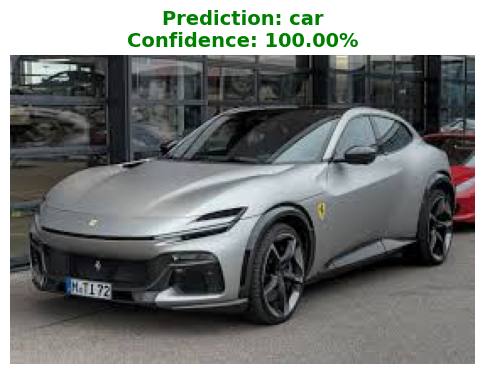

[*] Raw Probabilities: [1.0171125e-05 9.9996245e-01 1.2393974e-05 8.5578513e-06 6.4586407e-06]


In [ ]:
#LIVE INFERENCE
from google.colab import files
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn.functional as F

# 1. Define Inference Transform (Same as Validation)
inference_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

def predict_live(model, image_path, class_names):
    model.eval() # Set to evaluation mode

    # Load and Preprocess
    image = Image.open(image_path).convert('RGB')
    image_tensor = inference_transform(image).unsqueeze(0) # Add batch dimension
    image_tensor = image_tensor.to(DEVICE)

    # Predict
    with torch.no_grad():
        outputs = model(image_tensor)
        probabilities = F.softmax(outputs, dim=1)
        confidence, predicted_idx = torch.max(probabilities, 1)

    predicted_label = class_names[predicted_idx.item()]
    conf_score = confidence.item() * 100

    # Visualization
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.axis('off')

    # Set title color based on confidence (Green if high, Red if low)
    color = 'green' if conf_score > 70 else 'red'
    plt.title(f"Prediction: {predicted_label}\nConfidence: {conf_score:.2f}%",
              color=color, fontsize=14, fontweight='bold')
    plt.show()

    print(f"[*] Raw Probabilities: {probabilities[0].cpu().numpy()}")

# --- RUN INTERACTIVE SESSION ---
print("\n[+] Please upload an image to test (Building, Car, Lab, Person, or Tree):")
uploaded = files.upload()

for img_name in uploaded.keys():
    print(f"\n[*] Processing {img_name}...")
    # Using 'our_model' which is your Trained CBAM-DenseNet
    predict_live(our_model, img_name, class_names)